# set environment

In [89]:
import numpy as np
import pandas as pd
import os, re
import pickle
from   numba import jit, njit
import matplotlib.pyplot as plt

##############################################################
FP_LGG = "/data/Duke_BIOS824/LGG-segmentation/"
FP_OUT = "/data/Duke_BIOS824/res_proj01/"
FP_FIG = "/home/clint/GitRepo/Duke_BIOS824_Proj1/fig/"
patients = [x for x in os.listdir(FP_LGG) if "TCGA" in x]    

In [98]:
%load_ext rpy2.ipython
%matplotlib inline

# Read in the data

In [10]:
fp = open(FP_OUT + 'img_slice.pickle', 'rb')
img_slice = pickle.load(fp)
fp.close()

In [13]:
fp = open(FP_OUT + 'img_mask.pickle', 'rb')
img_mask = pickle.load(fp)
fp.close()

check dimension

In [14]:
print(len(img_slice))
print(len(img_mask))

110
110


In [15]:
print(img_slice['TCGA_CS_4941_19960909'].shape)
print(img_mask['TCGA_CS_4941_19960909'].shape)

(256, 256, 23, 3)
(256, 256, 23)


# Helper function

In [63]:
@njit
def get_neighbors(img, x, y, n):
    """get neighbors of a pixel (x, y)"""
    neighbors = np.array([
        img[xi, yi]
        for xi in range(x-n, x+n+1)
        for yi in range(y-n, y+n+1)
    ])
    return neighbors

@njit
def get_boundary(img, n = 2):
    """get the boundary of an image"""
    boundary = img.copy()                
    nr, nc = img.shape
    
    for xi in range(nr):
        for yi in range(nc):
            if img[xi, yi] != 0:
                neighbors = get_neighbors(img, xi, yi, n)
                if (np.all(neighbors == 255)):
                    boundary[xi, yi] = 0
                    
    return boundary

Test the function

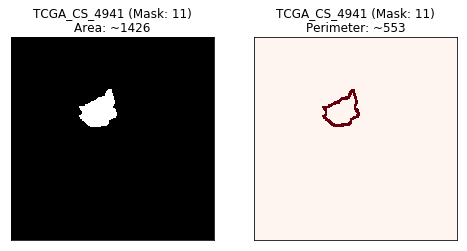

In [97]:
### chose a patient
img  = img_slice['TCGA_CS_4941_19960909']
mask = img_mask[ 'TCGA_CS_4941_19960909'] 

### get boundary from mask
img1 = mask[:, :, 10]
area = np.sum(img1 == 255)
img2 = get_boundary(img1, n = 3)
peri = np.sum(img2 == 255)

### visualization
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (8, 4))
axes = axes.ravel()
axes[0].imshow(img1, cmap = "gray")
axes[1].imshow(img2, cmap = "Reds")
axes[0].set_title("TCGA_CS_4941 (Mask: 11)\nArea: ~" + str(area))
axes[1].set_title("TCGA_CS_4941 (Mask: 11)\nPerimeter: ~" + str(peri))

### clear the axis
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

### store images
fname = FP_FIG + "area_perimeter_TCGA_CS_4941.png"
plt.savefig(fname, dpi = 300)    
pass

In [88]:
FP_FIG

'/home/clint/GitRepo/Duke_BIOS824_Proj1/fig'

In [87]:
!ls /data/Duke_BIOS824/res_proj01

img_mask.pickle  img_slice.pickle


# Calculate area and perimeter for all patients for all slices

In [83]:
dat = []

for pat in patients:
    ### init & chose a patient
    mask = img_mask[ pat] 
    
    ### loop over each mask
    for idx in range(mask.shape[2]):
        
        ### get area & boundary/perimeter from mask of each person
        img1 = mask[:, :, idx]
        area = np.sum(img1 == 255)
        img2 = get_boundary(img1, n = 3)
        peri = np.sum(img2 == 255)
        
        ### add the row
        row = (pat, idx, area, peri)
        dat.append(row)
        
### convert to data frame       
df_img_summary = pd.DataFrame(dat, columns=["Patient", "Slice", "Area", "Perimeter"])

check dimension

In [82]:
len(dat)

3929

In [ ]:
%%R -i df_img_summary

# Store the results

In [90]:
FP_OUT + "df_img_area_perimeter.csv"

'/data/Duke_BIOS824/res_proj01/df_img_area_perimeter.csv'

In [91]:
fname = FP_OUT + "df_img_area_perimeter.csv"
df_img_summary.to_csv(fname, index = False, header = True)

In [96]:
!head -20 /data/Duke_BIOS824/res_proj01/df_img_area_perimeter.csv

Patient,Slice,Area,Perimeter
TCGA_CS_4941_19960909,0,0,0
TCGA_CS_4941_19960909,1,0,0
TCGA_CS_4941_19960909,2,0,0
TCGA_CS_4941_19960909,3,0,0
TCGA_CS_4941_19960909,4,0,0
TCGA_CS_4941_19960909,5,0,0
TCGA_CS_4941_19960909,6,0,0
TCGA_CS_4941_19960909,7,0,0
TCGA_CS_4941_19960909,8,0,0
TCGA_CS_4941_19960909,9,0,0
TCGA_CS_4941_19960909,10,1426,553
TCGA_CS_4941_19960909,11,2646,956
TCGA_CS_4941_19960909,12,2765,1120
TCGA_CS_4941_19960909,13,2877,1362
TCGA_CS_4941_19960909,14,1952,1188
TCGA_CS_4941_19960909,15,1828,1020
TCGA_CS_4941_19960909,16,811,593
TCGA_CS_4941_19960909,17,74,74
TCGA_CS_4941_19960909,18,0,0


In [92]:
df_img_summary

,Patient,Slice,Area,Perimeter
0,TCGA_CS_4941_19960909,0,0,0
1,TCGA_CS_4941_19960909,1,0,0
2,TCGA_CS_4941_19960909,2,0,0
3,TCGA_CS_4941_19960909,3,0,0
4,TCGA_CS_4941_19960909,4,0,0
5,TCGA_CS_4941_19960909,5,0,0
6,TCGA_CS_4941_19960909,6,0,0
7,TCGA_CS_4941_19960909,7,0,0
8,TCGA_CS_4941_19960909,8,0,0
9,TCGA_CS_4941_19960909,9,0,0
